## The purpose of this project is to predict taxi cab fares before each ride

**Column name** - Description

**ID** - Trip identification number

**VendorID** - A code indicating the TPEP provider that provided the record.  

- 1= Creative Mobile Technologies, LLC; 

- 2= VeriFone Inc.

**tpep_pickup_datetime** - The date and time when the meter was engaged. 

**tpep_dropoff_datetime** - The date and time when the meter was disengaged. 

**Passenger_count** - The number of passengers in the vehicle.  
- This is a driver-entered value.

**Trip_distance** - The elapsed trip distance in miles reported by the taximeter.

**PULocationID** - TLC Taxi Zone in which the taximeter was engaged

**DOLocationID** - TLC Taxi Zone in which the taximeter was disengaged

**RateCodeID** - The final rate code in effect at the end of the trip. 

- 1 = Standard rate 

- 2=JFK 

- 3=Newark 

- 4=Nassau or Westchester 

- 5=Negotiated fare 

- 6=Group ride

**Store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before being sent to the vendor, aka “store and forward,”  because the vehicle did not have a connection to the server. 

- Y (1) = store and forward trip 

- N(0) = not a store and forward trip

**Payment_type** - A numeric code signifying how the passenger paid for the trip.  

- 1= Credit card 

- 2= Cash 

- 3= No charge 

- 4= Dispute 

- 5= Unknown 

- 6= Voided trip

**Fare_amount** - The time-and-distance fare calculated by the meter.

**Extra** - Miscellaneous extras and surcharges. Currently, this only includes the $0.50 and $1 rush hour and overnight charges.

**MTA_tax** - $0.50 MTA tax that is automatically triggered based on the metered rate in use.

**Improvement_surcharge** - $0.30 improvement surcharge assessed trips at the flag drop. The  improvement surcharge began being levied in 2015.

**Tip_amount** - Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.

**Tolls_amount** - Total amount of all tolls paid in trip. 

**Total_amount** - The total amount charged to passengers. Does not include cash tips.

In [1]:
import pandas as pd               
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns 

In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn import metrics

import joblib


In [3]:
import os

In [4]:
# Define the file path relative to your project directory
file_path = '../data/raw/2017_Yellow_Taxi_Trip_Data.csv'

# Load the CSV file into a DataFrame
data = pd.read_csv(file_path)

In [5]:
df = data.copy()

In [6]:
# view the first 5 rows
df.head()

Unnamed: 0  VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  \
0    24870114         2   03/25/2017 8:55:43 AM   03/25/2017 9:09:47 AM   
1    35634249         1   04/11/2017 2:53:28 PM   04/11/2017 3:19:58 PM   
2   106203690         1   12/15/2017 7:26:56 AM   12/15/2017 7:34:08 AM   
3    38942136         2   05/07/2017 1:17:59 PM   05/07/2017 1:48:14 PM   
4    30841670         2  04/15/2017 11:32:20 PM  04/15/2017 11:49:03 PM   

   passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0                6           3.34           1                  N   
1                1           1.80           1                  N   
2                1           1.00           1                  N   
3                1           3.70           1                  N   
4                1           4.37           1                  N   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
0           100           231             1         13.0    0.0      0.5   
1           186            43             1         16.0    0.0      0.5   
2           262           236             1          6.5    0.0      0.5   
3           188            97             1         20.5    0.0      0.5   
4             4           112             2         16.5    0.5      0.5   

   tip_amount  tolls_amount  improvement_surcharge  total_amount  
0        2.76           0.0                    0.3         16.56  
1        4.00           0.0                    0.3         20.80  
2        1.45           0.0                    0.3          8.75  
3        6.39           0.0                    0.3         27.69  
4        0.00           0.0                    0.3         17.80

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

In [8]:
#drop columns that are not relating to fare amount because they are gotten after the fare amount and cant be used for analyses or prediction
df = df.drop(['extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount'], axis=1)

In [9]:
# convert date and time columns to datetime data type , format = '%m/%d/%Y %H:%M:%S %p'
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

In [10]:
# rename 'Unnamed: 0' column to id
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [11]:
df['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
N    22600
Y       99
Name: count, dtype: int64

In [12]:
# Encode categorical variables
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

In [13]:
# Calculate the duration in minutes
df['duration'] = ((df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']) / np.timedelta64(1,'m')).round(2)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     22699 non-null  int64         
 1   VendorID               22699 non-null  int64         
 2   tpep_pickup_datetime   22699 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  22699 non-null  datetime64[ns]
 4   passenger_count        22699 non-null  int64         
 5   trip_distance          22699 non-null  float64       
 6   RatecodeID             22699 non-null  int64         
 7   store_and_fwd_flag     22699 non-null  int64         
 8   PULocationID           22699 non-null  int64         
 9   DOLocationID           22699 non-null  int64         
 10  payment_type           22699 non-null  int64         
 11  fare_amount            22699 non-null  float64       
 12  duration               22699 non-null  float64       
dtypes

In [15]:
#statistical description of the data
df.describe().T

count                           mean  \
id                     22699.0                56758486.171285   
VendorID               22699.0                       1.556236   
tpep_pickup_datetime     22699  2017-06-29 07:32:48.973126656   
tpep_dropoff_datetime    22699  2017-06-29 07:49:49.799726848   
passenger_count        22699.0                       1.642319   
trip_distance          22699.0                       2.913313   
RatecodeID             22699.0                       1.043394   
store_and_fwd_flag     22699.0                       0.004361   
PULocationID           22699.0                     162.412353   
DOLocationID           22699.0                     161.527997   
payment_type           22699.0                       1.336887   
fare_amount            22699.0                      13.026629   
duration               22699.0                      17.013766   

                                       min                         25%  \
id                                 12127.0                  28520556.0   
VendorID                               1.0                         1.0   
tpep_pickup_datetime   2017-01-01 00:08:25  2017-03-30 03:09:38.500000   
tpep_dropoff_datetime  2017-01-01 00:17:20  2017-03-30 03:11:20.500000   
passenger_count                        0.0                         1.0   
trip_distance                          0.0                        0.99   
RatecodeID                             1.0                         1.0   
store_and_fwd_flag                     0.0                         0.0   
PULocationID                           1.0                       114.0   
DOLocationID                           1.0                       112.0   
payment_type                           1.0                         1.0   
fare_amount                         -120.0                         6.5   
duration                            -16.98                        6.65   

                                       50%                  75%  \
id                              56731504.0           85374524.0   
VendorID                               2.0                  2.0   
tpep_pickup_datetime   2017-06-23 12:35:57  2017-10-02 10:34:34   
tpep_dropoff_datetime  2017-06-23 12:55:11  2017-10-02 10:53:47   
passenger_count                        1.0                  2.0   
trip_distance                         1.61                 3.06   
RatecodeID                             1.0                  1.0   
store_and_fwd_flag                     0.0                  0.0   
PULocationID                         162.0                233.0   
DOLocationID                         162.0                233.0   
payment_type                           1.0                  2.0   
fare_amount                            9.5                 14.5   
duration                             11.18                18.38   

                                       max              std  
id                             113486300.0  32744929.492148  
VendorID                               2.0         0.496838  
tpep_pickup_datetime   2017-12-31 23:45:30              NaN  
tpep_dropoff_datetime  2017-12-31 23:49:24              NaN  
passenger_count                        6.0         1.285231  
trip_distance                        33.96         3.653171  
RatecodeID                            99.0         0.708391  
store_and_fwd_flag                     1.0         0.065898  
PULocationID                         265.0        66.633373  
DOLocationID                         265.0        70.139691  
payment_type                           4.0         0.496211  
fare_amount                         999.99        13.243791  
duration                           1439.55        61.996476

**passenger_count**
- it has a mean of 1.64, indicating most rides have 1 or 2 passengers.
- The maximum value is 6, which seems reasonable.

**trip_distance:**
- it has a Mean of 2.91 miles, with a wide range (0 to 33.96 miles).
- it has a maximum of 33.96 miles, which might be an outlier considering the 75th % is 3.06 miles 

**RatecodeID:**
- it has a mean of 1.04, indicating that most trips are likely to be standard rate (RatecodeID 1).
- The maximum value is 99, which might be an error (since the RatecodeID can only be from 1 to 6)

**store_and_fwd_flag:**
- Mean: 0.004, indicating that the flag is rarely set to 'Y' (almost always 'N').


**payment_type:**

- Mean: 1.34, suggesting most payments are of type 1 (credit card).
- There are four payment types (1 to 4) in the data.

**fare_amount:**
- Mean: $13.03, but with a very wide range and some outliers (minimum of -120 and maximum of 999.99).


### vendor id

<Axes: xlabel='VendorID', ylabel='count'>

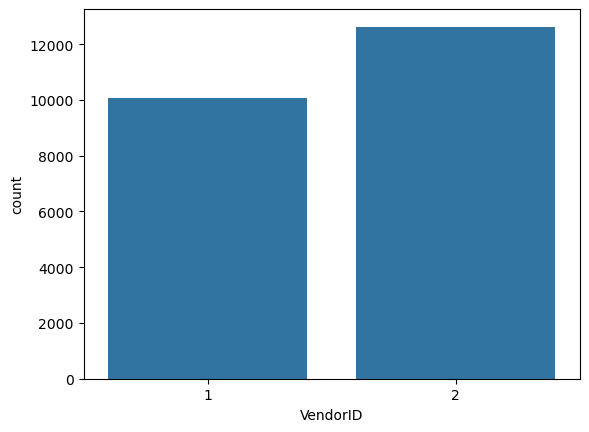

In [16]:
sns.countplot(x='VendorID',data=df)

there is not much difference between the trips taken by both vendors

### passenger count

In [17]:
df['passenger_count'].value_counts()

passenger_count
1    16117
2     3305
5     1143
3      953
6      693
4      455
0       33
Name: count, dtype: int64

about 70% of the rides were single occupancy, though there were still nearly 700 rides with as many as six passengers. 

Also, there are 33 rides with an occupancy count of zero, which doesn't make sense. These would likely be dropped unless a reasonable explanation can be found for them.

In [18]:
df[df['passenger_count'] == 0].head(10)

id  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
1516   96563556         1  2017-11-14 15:45:23   2017-11-14 16:26:38   
1874  102273749         1  2017-12-03 12:05:52   2017-12-03 12:13:51   
1925   75654951         1  2017-09-09 03:44:45   2017-09-09 03:49:19   
3352  107464306         1  2017-12-18 22:44:57   2017-12-18 23:00:24   
4060  100326273         1  2017-11-27 13:08:01   2017-11-27 13:17:55   
4919  106693550         1  2017-12-16 14:59:17   2017-12-16 15:21:59   
5563   74279671         1  2017-09-04 17:40:00   2017-09-04 17:51:52   
5603  107019016         1  2017-12-17 12:18:49   2017-12-17 12:40:45   
5668  106785624         1  2017-12-16 19:50:12   2017-12-16 20:00:30   
5767   83401081         1  2017-10-04 15:17:52   2017-10-04 15:56:26   

      passenger_count  trip_distance  RatecodeID  store_and_fwd_flag  \
1516                0            8.8           1                   0   
1874                0            1.1           1                   0   
1925                0            0.8           1                   0   
3352                0            2.7           1                   0   
4060                0            1.7           1                   0   
4919                0            3.1           1                   0   
5563                0            1.3           1                   0   
5603                0            4.2           1                   0   
5668                0            1.0           1                   0   
5767                0           10.4           1                   0   

      PULocationID  DOLocationID  payment_type  fare_amount  duration  
1516           138           164             1         33.0     41.25  
1874            48           237             2          7.0      7.98  
1925            48            48             2          5.0      4.57  
3352            87            79             1         12.5     15.45  
4060           161           239             1          9.0      9.90  
4919           163           114             1         15.5     22.70  
5563           164           233             1          9.0     11.87  
5603           230           211             1         18.0     21.93  
5668           211           249             1          8.0     10.30  
5767           113           138             1         34.0     38.57

In [19]:
# deleting the rows with passenger count < 0
df = df[df['passenger_count'] > 0]

In [20]:
(df['passenger_count'] < 0).sum()

0

In [21]:
df['passenger_count'].value_counts().reset_index()

passenger_count  count
0                1  16117
1                2   3305
2                5   1143
3                3    953
4                6    693
5                4    455

### OUTLIERS

Keeping in mind that many of the features will not be used to fit your model, the most important columns to check for outliers are likely to be:

- trip_distance
- fare_amount
- duration

#### trip_distance

In [22]:
# funcion to visualize boxplot, and histogram with KDE
def visualize_distribution(data, column_name):
    """
    Visualize the distribution of a column using boxplot and histogram with KDE.
    
    Parameters:
        data (DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to visualize.
    """
    # Set up the matplotlib figure
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Boxplot
    sns.boxplot(x=data[column_name], ax=axes[0])
    axes[0].set_title(f'Boxplot of {column_name}')
    
     # Add a red triangle marker for the mean
    mean_value = data[column_name].mean()
    axes[0].scatter(mean_value, 0, color='red', marker='^', s=100, label='Mean')
    
    # Histogram with KDE
    sns.histplot(data[column_name], kde=True, ax=axes[1])
    axes[1].set_title(f'Histogram with KDE of {column_name}')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()

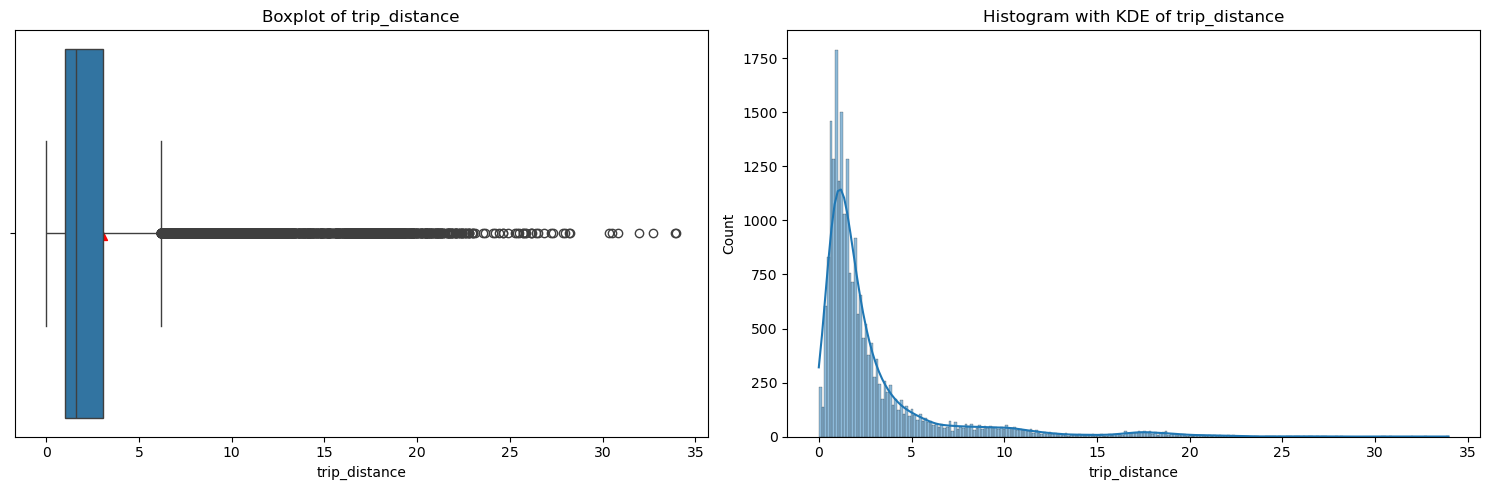

In [23]:
#visualaziation  of Trip Distance
visualize_distribution(df, 'trip_distance')

- The majority of trips were journeys of 0-5 miles. 
- The number of trips falls away steeply as the distance traveled increases beyond that.
- the distribution is right skewed

The distance between 2 places can be up to 30 miles and that also depends on the routes.

With this knowledge and the distribution of the values in the `trip_distance` column, it's reasonable to leave these values alone and not alter them. 

but lets look at the trip distance of 0

In [24]:
(df['trip_distance'] == 0).sum()

147

In [25]:
df[df['trip_distance'] == 0].head(10)

id  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
128   52987734         1  2017-06-22 08:05:33   2017-06-22 08:05:40   
246   78660848         1  2017-09-18 20:50:53   2017-09-18 20:51:03   
291   83480088         1  2017-10-04 19:46:24   2017-10-04 19:46:50   
319   14024301         1  2017-02-22 04:01:44   2017-02-22 04:01:53   
424    3767951         1  2017-01-14 07:00:26   2017-01-14 07:00:53   
470  103583013         2  2017-12-07 14:39:18   2017-12-07 14:39:23   
472   52474677         1  2017-06-20 18:57:39   2017-06-20 18:57:39   
572   61050418         2  2017-07-18 13:29:06   2017-07-18 13:29:19   
647   20816132         1  2017-03-12 22:28:27   2017-03-12 22:28:30   
795  101135030         1  2017-11-30 07:11:34   2017-11-30 07:11:34   

     passenger_count  trip_distance  RatecodeID  store_and_fwd_flag  \
128                1            0.0           3                   0   
246                1            0.0           1                   0   
291                1            0.0           1                   0   
319                1            0.0           1                   0   
424                1            0.0           1                   0   
470                1            0.0           5                   0   
472                1            0.0           1                   0   
572                1            0.0           2                   0   
647                1            0.0           1                   0   
795                1            0.0           1                   0   

     PULocationID  DOLocationID  payment_type  fare_amount  duration  
128           231           231             2         20.0      0.12  
246           145           145             2          2.5      0.17  
291           132           132             2          2.5      0.43  
319            90            90             3          2.5      0.15  
424           208           208             1          2.5      0.45  
470           138           138             1         34.0      0.08  
472           162           264             2          9.5      0.00  
572           230           161             1         52.0      0.22  
647           143           143             1          2.5      0.05  
795           246           264             2          8.0      0.00

#### `trip_distance` outliers

You know from the summary statistics that there are trip distances of 0. Are these reflective of erroneous data, or are they very short trips that get rounded down?

To check, sort the column values, eliminate duplicates, and inspect the least 10 values. Are they rounded values or precise values?

In [26]:
# Are trip distances of 0 bad data or very short trips rounded down?
sorted(set(df['trip_distance']))[:10]

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

The distances are captured with a high degree of precision. However, it might be possible for trips to have distances of zero if a passenger summoned a taxi and then changed their mind. Besides, are there enough zero values in the data to pose a problem?


148 out of ~23,000 rides is relatively insignificant. we could delete the rows or cjange the values to 0.01 but it's unlikely to have much of an effect on the model. Therefore, the `trip_distance` column will remain untouched with regard to outliers.

#### `fare_amount` outliers

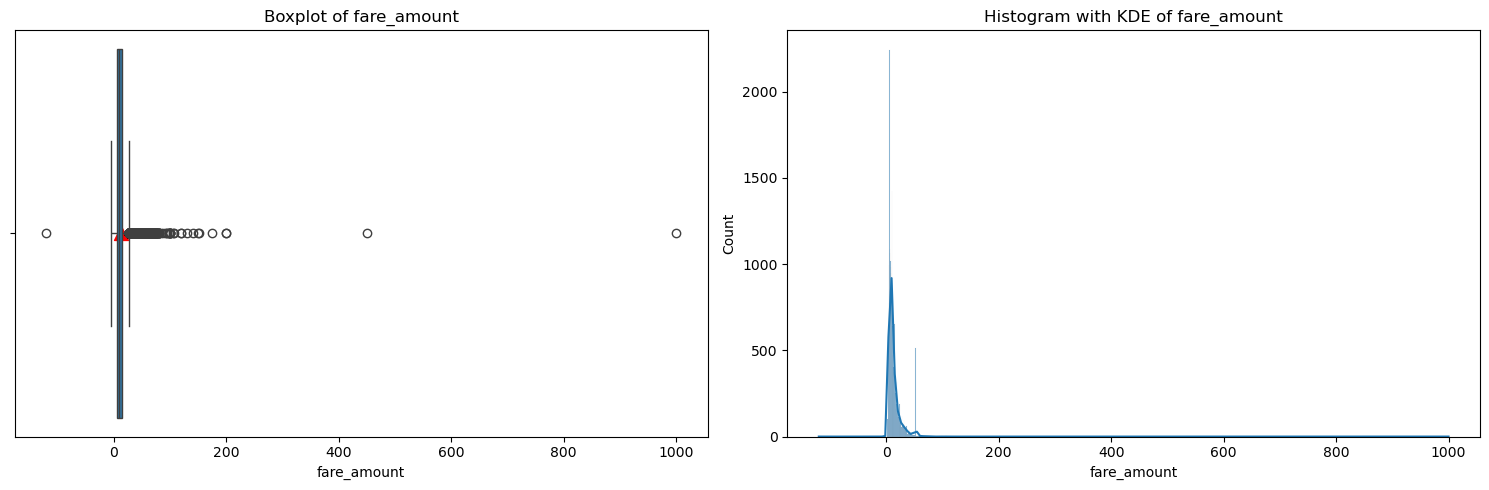

In [27]:
#visualaziation  of Fare Amount
visualize_distribution(df, 'fare_amount')

In [28]:
df[['fare_amount']].describe().T

count       mean        std    min  25%  50%   75%     max
fare_amount  22666.0  13.024983  13.243745 -120.0  6.5  9.5  14.5  999.99

The range of values in the `fare_amount` column is large and the extremes don't make much sense.

* **Low values:** Negative values are problematic. 
- lets view the negative values
- Values of zero could be legitimate if the taxi logged a trip that was immediately canceled.

* **High values:** The maximum fare amount in this dataset is nearly \\$1,000, which seems very unlikely. 

- High values for this feature can be capped based on intuition and statistics. 
- The interquartile range (IQR) is \\$8. The standard formula of `Q3 + (1.5 * IQR)` yields \$26.50. That doesn't seem appropriate for the maximum fare cap. In this case, we'll use a factor of `6`, which results in a cap of $62.50.


In [29]:
(df['fare_amount'] < 0).sum()

14

In [30]:
df[df['fare_amount'] < 0]

id  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
314    105454287         2  2017-12-13 02:02:39   2017-12-13 02:03:08   
1646    57337183         2  2017-07-05 11:02:23   2017-07-05 11:03:00   
4423    97329905         2  2017-11-16 20:13:30   2017-11-16 20:14:50   
5448    28459983         2  2017-04-06 12:50:26   2017-04-06 12:52:39   
5758      833948         2  2017-01-03 20:15:23   2017-01-03 20:15:39   
8204    91187947         2  2017-10-28 20:39:36   2017-10-28 20:41:59   
10281   55302347         2  2017-06-05 17:34:25   2017-06-05 17:36:29   
11204   58395501         2  2017-07-09 07:20:59   2017-07-09 07:23:50   
12944   29059760         2  2017-04-08 00:00:16   2017-04-08 23:15:57   
14714  109276092         2  2017-12-24 22:37:58   2017-12-24 22:41:08   
17602   24690146         2  2017-03-24 19:31:13   2017-03-24 19:34:49   
18565   43859760         2  2017-05-22 15:51:20   2017-05-22 15:52:22   
20317   75926915         2  2017-09-09 22:59:51   2017-09-09 23:02:06   
20698   14668209         2  2017-02-24 00:38:17   2017-02-24 00:42:05   

       passenger_count  trip_distance  RatecodeID  store_and_fwd_flag  \
314                  6           0.12           1                   0   
1646                 1           0.04           1                   0   
4423                 2           0.06           1                   0   
5448                 1           0.25           1                   0   
5758                 1           0.02           1                   0   
8204                 1           0.41           1                   0   
10281                2           0.00           1                   0   
11204                1           0.64           1                   0   
12944                1           0.17           5                   0   
14714                5           0.40           1                   0   
17602                1           0.46           1                   0   
18565                1           0.10           1                   0   
20317                1           0.24           1                   0   
20698                1           0.70           1                   0   

       PULocationID  DOLocationID  payment_type  fare_amount  duration  
314             161           161             3         -2.5      0.48  
1646             79            79             3         -2.5      0.62  
4423            237           237             4         -3.0      1.33  
5448             90            68             3         -3.5      2.22  
5758            170           170             3         -2.5      0.27  
8204            236           237             3         -3.5      2.38  
10281           238           238             4         -2.5      2.07  
11204            50            48             3         -4.5      2.85  
12944           138           138             4       -120.0   1395.68  
14714           164           161             4         -4.0      3.17  
17602            87            45             4         -4.0      3.60  
18565           230           163             3         -3.0      1.03  
20317           116           116             4         -3.5      2.25  
20698            65            25             4         -4.5      3.80

the negative values all have a payent type of 3 (no charge) and 4(dispute) which probably means they werent charged for it or they encountered an issue in the trip

the values wil be deleted

In [31]:
# deleting the rows with fare amount < 0
df = df[df['fare_amount'] >= 0]

In [32]:
bshape = df.shape
print(f"df shape: {bshape}")

# Calculate the quartiles
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Calculate the upper cap using a factor of 6
upper_cap = Q3 + 6 * IQR

# Printing the upper cap for fare_amount
print(f"Upper Cap for fare_amount: {upper_cap}")

# Delete rows where fare_amount is greater than the upper cap
df = df[df['fare_amount'] <= upper_cap]

ashape = df.shape
print(f"df shape: {ashape}")

df shape: (22652, 13)
Upper Cap for fare_amount: 62.5
df shape: (22571, 13)


In [33]:
df[['fare_amount']].describe().T

count       mean        std  min  25%  50%   75%   max
fare_amount  22571.0  12.726717  10.129139  0.0  6.5  9.5  14.5  62.5

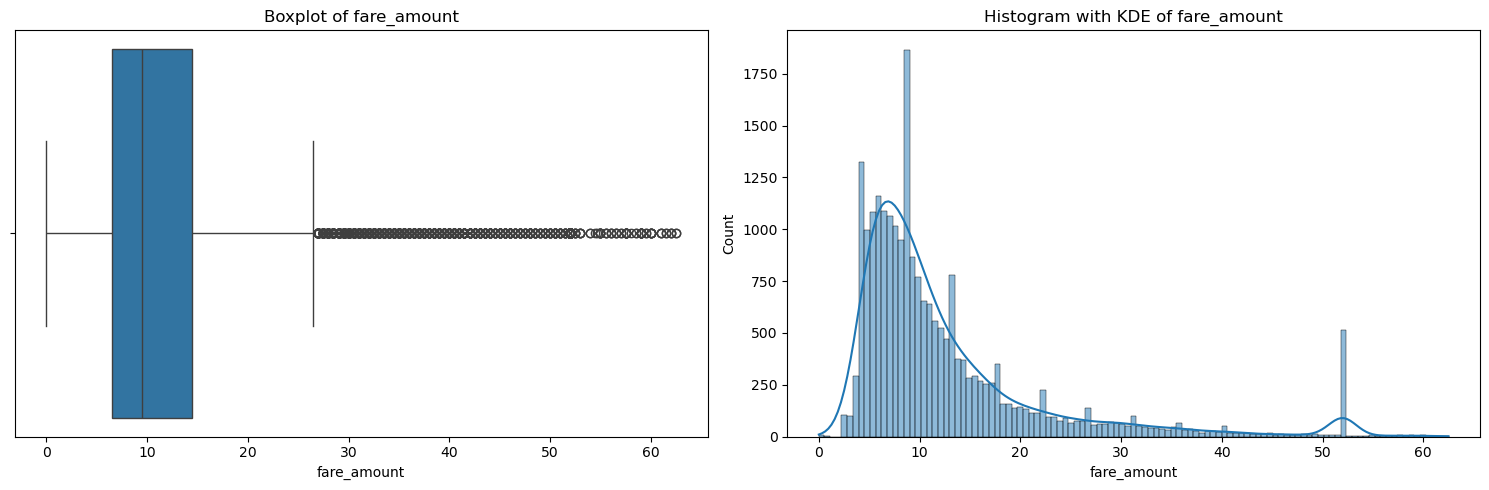

In [34]:
#visualaziation  of new Fare Amount
visualize_distribution(df, 'fare_amount')

### duration

In [35]:
df[['duration']].describe().T

count       mean        std    min   25%    50%    75%      max
duration  22571.0  16.874072  61.441716 -16.98  6.65  11.17  18.28  1439.55

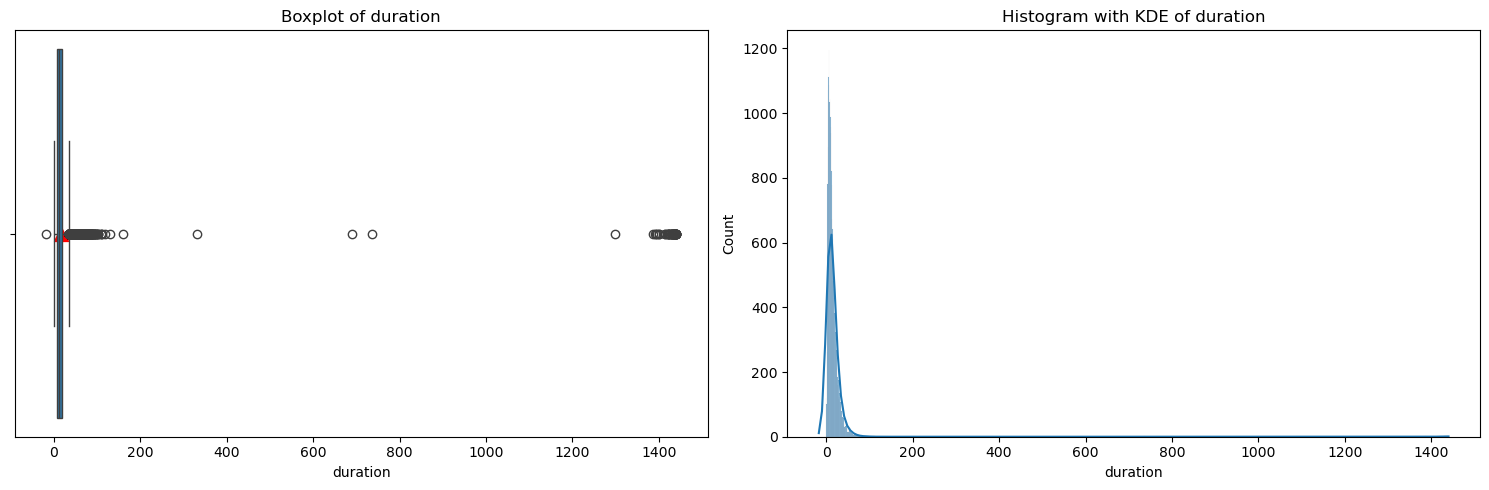

In [36]:
visualize_distribution(df, 'duration')

In [37]:
df[df['duration'] < 0]

id  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
9356  93542707         1  2017-11-05 01:23:08   2017-11-05 01:06:09   

      passenger_count  trip_distance  RatecodeID  store_and_fwd_flag  \
9356                1            5.7           1                   0   

      PULocationID  DOLocationID  payment_type  fare_amount  duration  
9356           161           157             3         28.0    -16.98

duration only has one negative value and thats because the pickup time is greater than the drop off time, thats probably a mistake but it will be deleted

The `duration` column has problematic values at both the lower and upper extremities.

* **Low values:** There should be no values that represent negative time. delete all negative durations with `0`.

* **High values:** Impute high values the same way you imputed the high-end outliers for fares: `Q3 + (6 * IQR)`.

In [38]:
# deleting rows that are less than 0 (-ve duration values)
df = df[df['duration'] >= 0]

In [39]:
bshape = df.shape
print(f"df shape: {bshape}")

# Calculate the quartiles
Q1 = df['duration'].quantile(0.25)
Q3 = df['duration'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Calculate the upper cap using a factor of 6
upper_cap = Q3 + 6 * IQR

# Printing the upper cap for duration
print(f"Upper Cap for duration: {upper_cap}")

# Delete rows where duration is greater than the upper cap
df = df[df['duration'] <= upper_cap]

ashape = df.shape
print(f"df shape: {ashape}")

df shape: (22570, 13)
Upper Cap for duration: 88.06
df shape: (22504, 13)


In [40]:
df[['duration']].describe().T

count       mean       std  min   25%    50%   75%    max
duration  22504.0  14.154529  11.08095  0.0  6.63  11.13  18.2  87.95

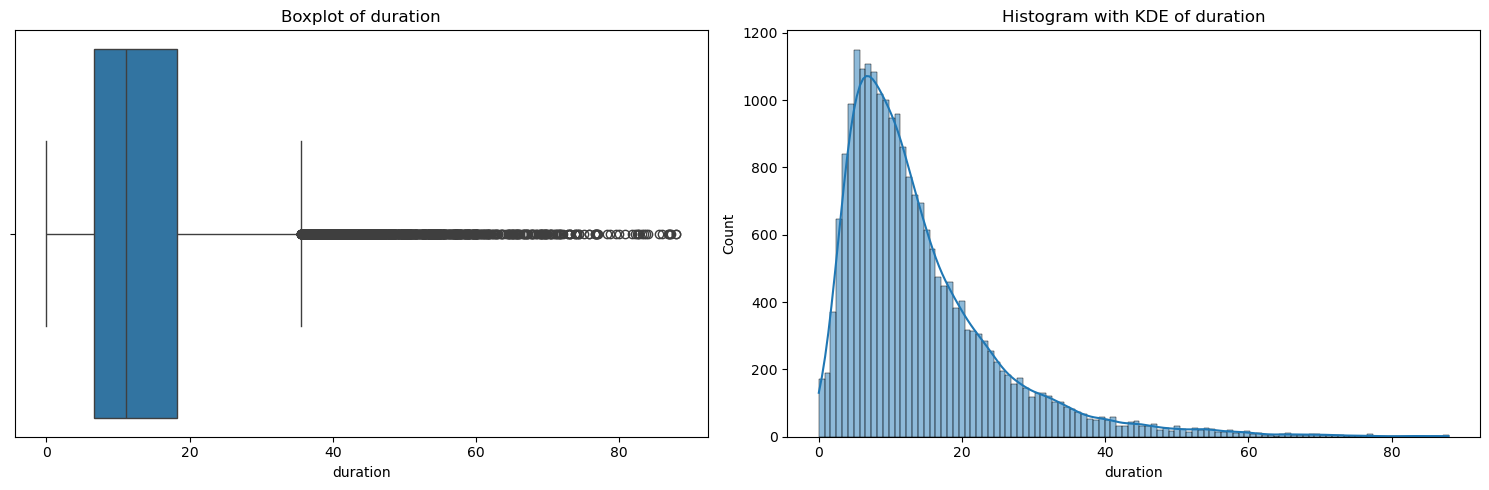

In [41]:
visualize_distribution(df, 'duration')

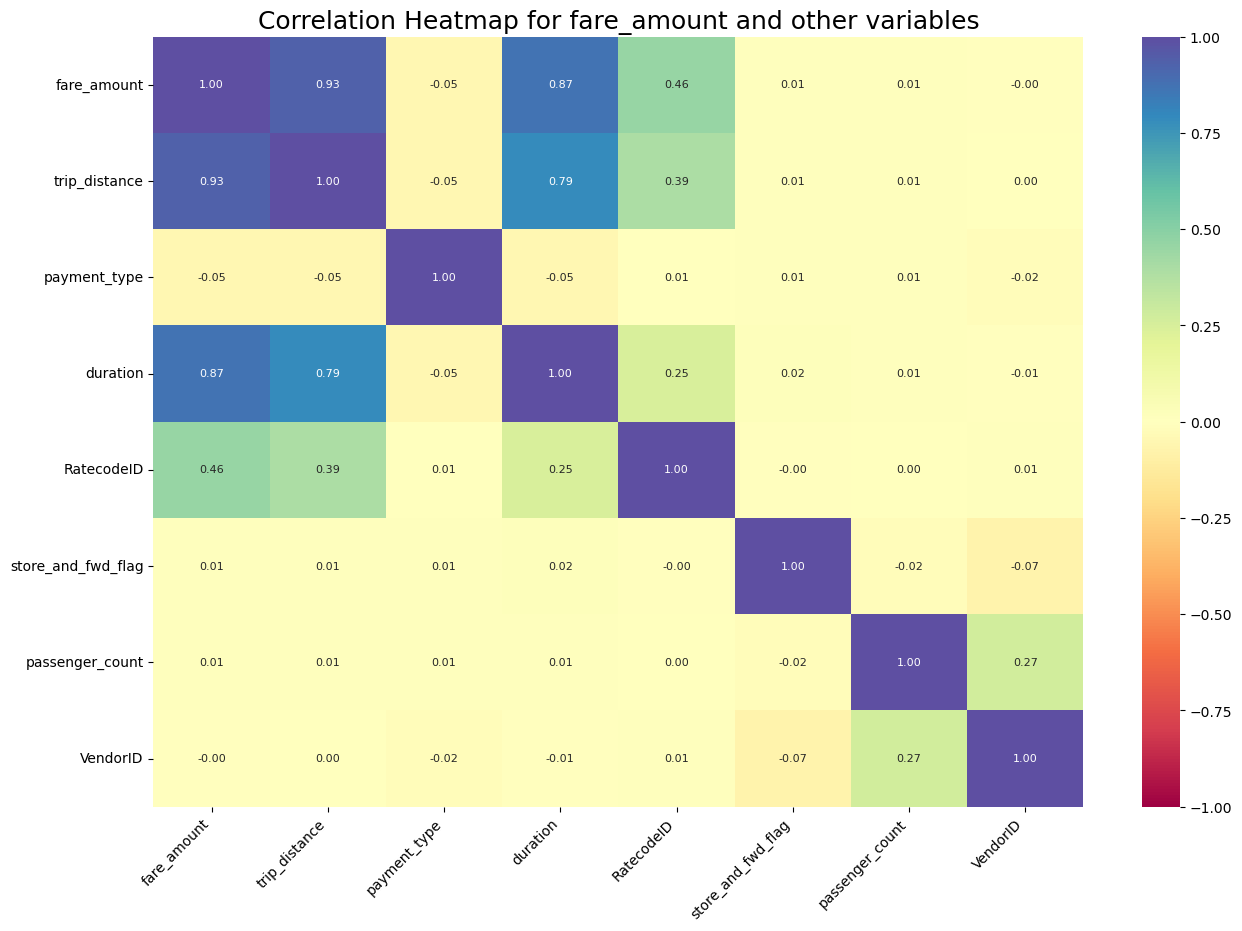

In [42]:

# List of columns to focus on, including 'fare_amount'
columns_of_interest = ['fare_amount', 'trip_distance', 'payment_type', 'duration', 'RatecodeID', 'store_and_fwd_flag', 'passenger_count', 'VendorID']  # Add other relevant columns as needed

# Create a subset of the DataFrame with these columns
df_subset = df[columns_of_interest]

# Increase the figure size for better readability
plt.figure(figsize=(15, 10))

# Create the heatmap with more suitable settings for better readability
sns.heatmap(df_subset.corr(method='pearson'), annot=True, cmap='Spectral', fmt='.2f', annot_kws={"size": 8}, vmin = -1, vmax = 1)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title with an increased font size
plt.title('Correlation Heatmap for fare_amount and other variables', fontsize=18)

# Display the heatmap
plt.show()


trip_distance, duration, ratecodeID are highly correlated with fare_amount

### Feature Engineering

When deployed, the model will not know the duration of a trip until after the trip occurs, so we cannot train a model that uses this feature. However, we can use the statistics of trips we know to generalize about ones we do not know.

create 2 columns called `mean_distance` and `mean_duration` that captures the **mean distance** and **mean duration** for each group of trips that share pickup and dropoff points.

In [43]:
# Calculate mean distance and mean duration for each group of trips
mean_values = df.groupby(['PULocationID', 'DOLocationID']).agg({
    'trip_distance': 'mean', 
    'duration': 'mean'
}).reset_index()

# Rename the columns to mean_distance and mean_duration
mean_values.rename(columns={'trip_distance': 'mean_distance', 'duration': 'mean_duration'}, inplace=True)

mean_values.head()

PULocationID  DOLocationID  mean_distance  mean_duration
0             1             1           0.00          0.380
1             4             4           0.32          1.825
2             4            37           5.48         21.500
3             4            45           2.24          9.250
4             4            74           5.59         20.430

In [44]:
# Define the path to save mean_values.csv
save_path = '../data/processed/mean_values.csv'

# Save mean_values DataFrame to CSV
mean_values.to_csv(save_path, index=False)

# Now mean_values.csv is saved in the processed folder


In [45]:
# Merge the mean values back into the original DataFrame
df = df.merge(mean_values, on=['PULocationID', 'DOLocationID'], how='left')

df.head()

id  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0   24870114         2  2017-03-25 08:55:43   2017-03-25 09:09:47   
1   35634249         1  2017-04-11 14:53:28   2017-04-11 15:19:58   
2  106203690         1  2017-12-15 07:26:56   2017-12-15 07:34:08   
3   38942136         2  2017-05-07 13:17:59   2017-05-07 13:48:14   
4   30841670         2  2017-04-15 23:32:20   2017-04-15 23:49:03   

   passenger_count  trip_distance  RatecodeID  store_and_fwd_flag  \
0                6           3.34           1                   0   
1                1           1.80           1                   0   
2                1           1.00           1                   0   
3                1           3.70           1                   0   
4                1           4.37           1                   0   

   PULocationID  DOLocationID  payment_type  fare_amount  duration  \
0           100           231             1         13.0     14.07   
1           186            43             1         16.0     26.50   
2           262           236             1          6.5      7.20   
3           188            97             1         20.5     30.25   
4             4           112             2         16.5     16.72   

   mean_distance  mean_duration  
0       3.521667      22.848333  
1       3.108889      24.470000  
2       0.881429       7.250286  
3       3.700000      30.250000  
4       4.435000      14.620000

In [46]:
# Confirm that it worked
df[(df['PULocationID'] == 100) & (df['DOLocationID'] == 231)][['mean_distance', 'mean_duration']]


mean_distance  mean_duration
0           3.521667      22.848333
4864        3.521667      22.848333
16484       3.521667      22.848333
17975       3.521667      22.848333
19587       3.521667      22.848333
20402       3.521667      22.848333

Create new columns, `pickup_day` (name of day), `pickup_hour` (hour of the day),  and `pickup_month` (name of month) by extracting the relevant information from the `tpep_pickup_datetime` column.

In [47]:
# Create a new column for the hour of the day
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

# Create a new column for the day of the week 
df['pickup_dayofweek_name'] = df['tpep_pickup_datetime'].dt.day_name().str.lower()

# Create a new column for the day of the week (0=Monday, 6=Sunday)
df['pickup_day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek

# Create a new column for the month (1=January, 12=December)
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month

# Create a new column for the month name
df['pickup_month_name'] = df['tpep_pickup_datetime'].dt.strftime('%b')


Next, I have defined a function that lets us determine what time of the day the ride was taken. I have created 4 time zones ‘Morning’ (from 6:00 am to 11:59 pm), ‘Afternoon’ (from 12 noon to 3:59 pm), ‘Evening’ (from 4:00 pm to 9:59 pm), and ‘Late Night’ (from 10:00 pm to 5:59 am)

In [48]:
def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Late night'

In [49]:
df['pickup_timeofday'] = df['pickup_hour'].apply(time_of_day)

In [50]:
pd.set_option('display.max_columns', None)
df.head()

id  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0   24870114         2  2017-03-25 08:55:43   2017-03-25 09:09:47   
1   35634249         1  2017-04-11 14:53:28   2017-04-11 15:19:58   
2  106203690         1  2017-12-15 07:26:56   2017-12-15 07:34:08   
3   38942136         2  2017-05-07 13:17:59   2017-05-07 13:48:14   
4   30841670         2  2017-04-15 23:32:20   2017-04-15 23:49:03   

   passenger_count  trip_distance  RatecodeID  store_and_fwd_flag  \
0                6           3.34           1                   0   
1                1           1.80           1                   0   
2                1           1.00           1                   0   
3                1           3.70           1                   0   
4                1           4.37           1                   0   

   PULocationID  DOLocationID  payment_type  fare_amount  duration  \
0           100           231             1         13.0     14.07   
1           186            43             1         16.0     26.50   
2           262           236             1          6.5      7.20   
3           188            97             1         20.5     30.25   
4             4           112             2         16.5     16.72   

   mean_distance  mean_duration  pickup_hour pickup_dayofweek_name  \
0       3.521667      22.848333            8              saturday   
1       3.108889      24.470000           14               tuesday   
2       0.881429       7.250286            7                friday   
3       3.700000      30.250000           13                sunday   
4       4.435000      14.620000           23              saturday   

   pickup_day_of_week  pickup_month pickup_month_name pickup_timeofday  
0                   5             3               Mar          Morning  
1                   1             4               Apr        Afternoon  
2                   4            12               Dec          Morning  
3                   6             5               May        Afternoon  
4                   5             4               Apr       Late night

## EDA

## Trips and Date Time Analysis

### Trips and trips duration per Day of the week

C:\Users\HP\AppData\Local\Temp\ipykernel_5816\11468080.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="pickup_dayofweek_name", data=df, ax=ax1, palette='Spectral')


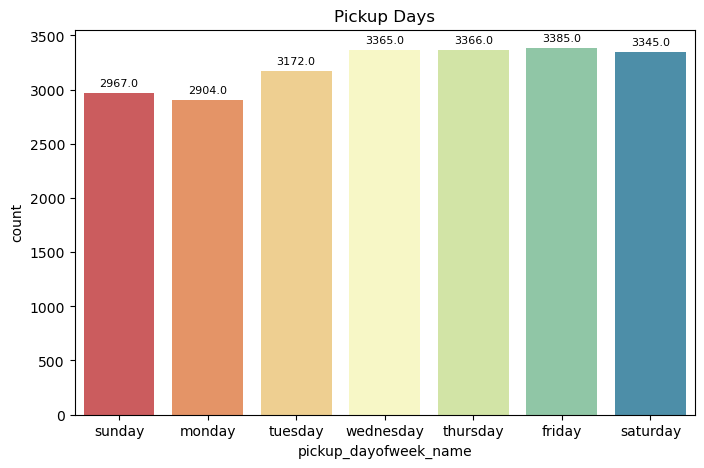

In [51]:

# Use pandas Categorical to order the months correctly
df['pickup_dayofweek_name'] = pd.Categorical(df['pickup_dayofweek_name'], 
                                    categories=[ 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday'], 
                                    ordered=True)

# Create the plot
figure, ax1 = plt.subplots(figsize=(8, 5))
ax1.set_title('Pickup Days')

# Plot the count plot
ax = sns.countplot(x="pickup_dayofweek_name", data=df, ax=ax1, palette='Spectral')

# Annotate the bars with counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')

# Show the plot
plt.show()


We see wednesday are the busiest days followed by friday, thursdays, and Saturdays. 


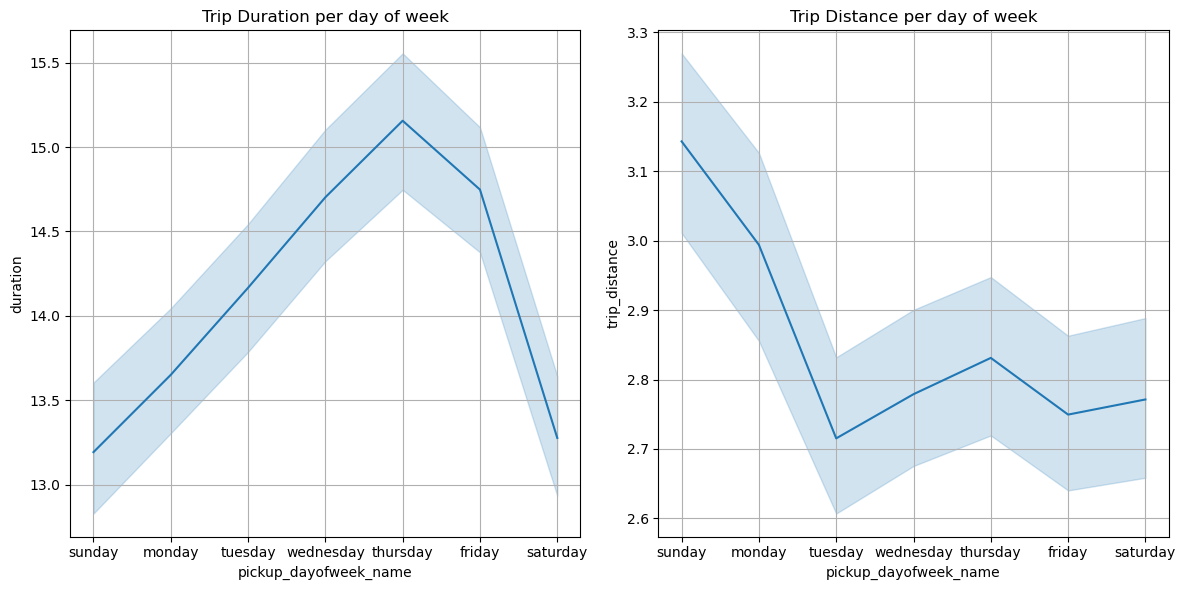

In [52]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot for Trip Duration per time of day
sns.lineplot(x='pickup_dayofweek_name', y='duration', data=df, ax=axes[0])
axes[0].set_title('Trip Duration per day of week')
axes[0].grid(True)  # Enable grid

# Plot for Trip Distance per time of day
sns.lineplot(x='pickup_dayofweek_name', y='trip_distance', data=df, ax=axes[1])
axes[1].set_title('Trip Distance per day of week')
axes[1].grid(True)  # Enable grid

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


- Trip duration is the longest on Thursdays closely followed by Fridays.
- trip duration increases steadily from sunday to thursday and reduces again steadily

- Distances are longer on Sundays probably because it’s weekend.
- Monday trip distances are also quite high.


### Trips and trip duration per month

C:\Users\HP\AppData\Local\Temp\ipykernel_5816\246486601.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='pickup_month_name', data=df, palette='Spectral', ax=ax2)


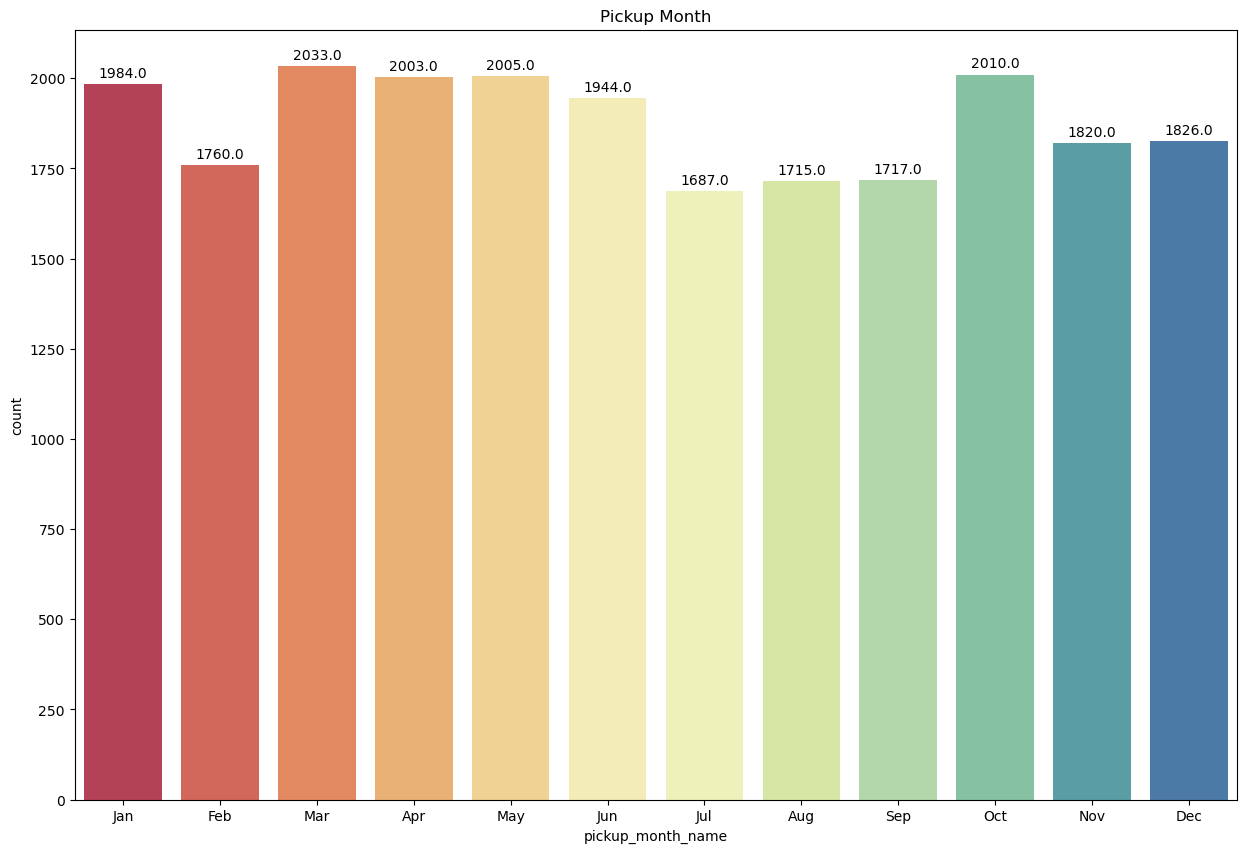

In [53]:
# Use pandas Categorical to order the months correctly
df['pickup_month_name'] = pd.Categorical(df['pickup_month_name'], 
                                    categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
                                    ordered=True)

# Create the plot
figure, ax2 = plt.subplots(figsize=(15, 10))
ax2.set_title('Pickup Month')

# Plot the count plot
ax = sns.countplot(x='pickup_month_name', data=df, palette='Spectral', ax=ax2)

# Annotate the bars with counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Show the plot
plt.show()


There is not much difference in the number of trips across months.

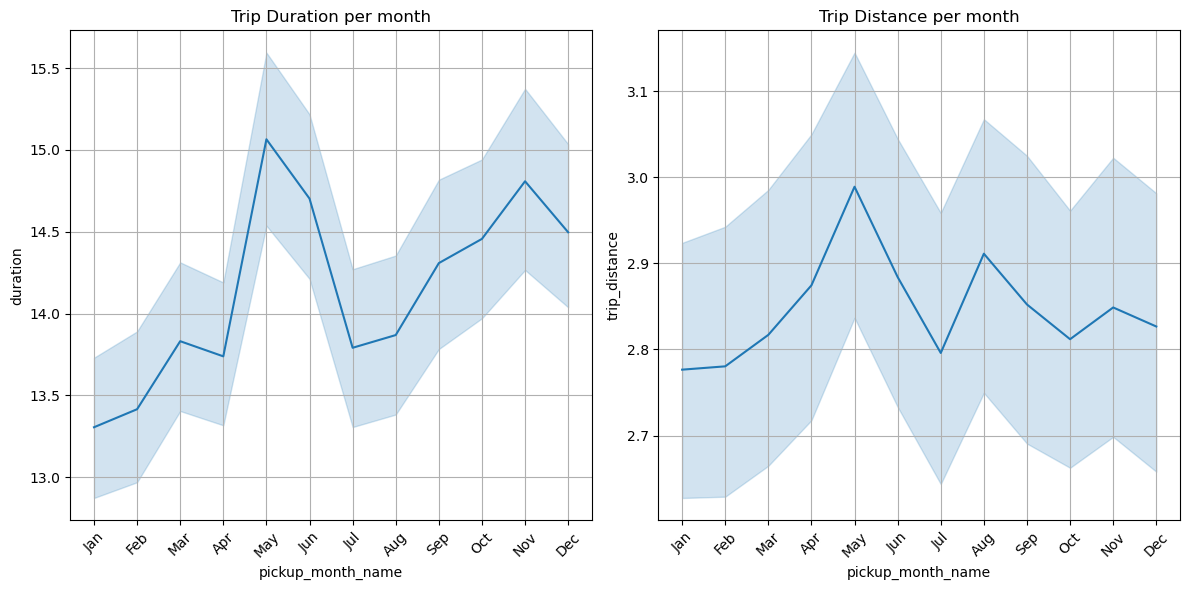

In [54]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot for Trip Duration per time of day
sns.lineplot(x='pickup_month_name', y='duration', data=df, ax=axes[0])
axes[0].set_title('Trip Duration per month')
axes[0].grid(True)  # Enable grid
axes[0].tick_params(axis='x', rotation=45) 

# Plot for Trip Distance per time of day
sns.lineplot(x='pickup_month_name', y='trip_distance', data=df, ax=axes[1])
axes[1].set_title('Trip Distance per month')
axes[1].grid(True)  # Enable grid
axes[1].tick_params(axis='x', rotation=45) 

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


The trip duration is highest in May and June, and lowest in January and February. 

may and june is summer, meaning better weather conditions, people are more likely to go out leading to traffic and longer trip times


### Trips and trip duration per Hour

C:\Users\HP\AppData\Local\Temp\ipykernel_5816\42181298.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="pickup_hour", data=df, ax=ax2, palette='Spectral')


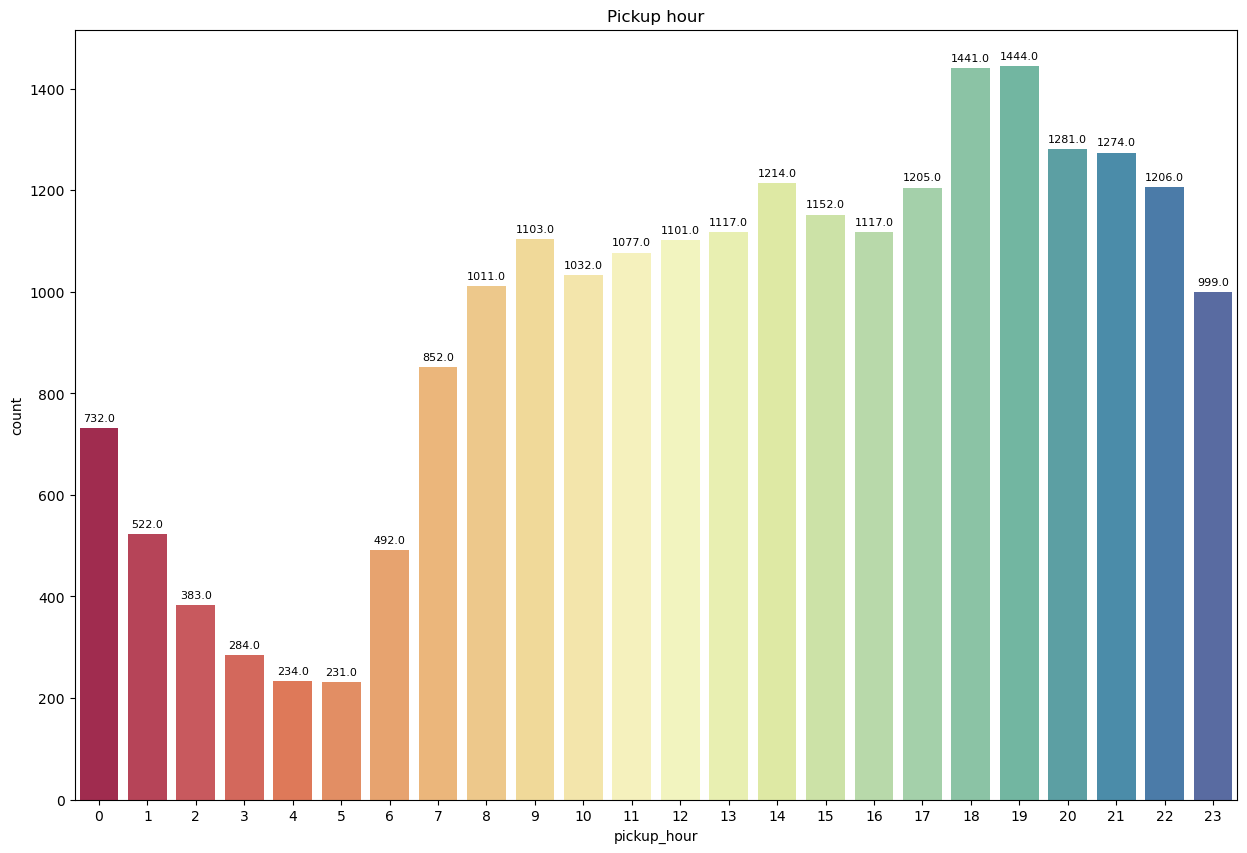

In [55]:
# Create the plot
figure, ax2 = plt.subplots(figsize=(15, 10))
ax2.set_title('Pickup hour')

# Plot the count plot
ax = sns.countplot(x="pickup_hour", data=df, ax=ax2, palette='Spectral')

# Annotate the bars with counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')

# Show the plot
plt.show()


6pm to 7pm has the highest number of trips

that makes sense as thats the time when people return from their offices.

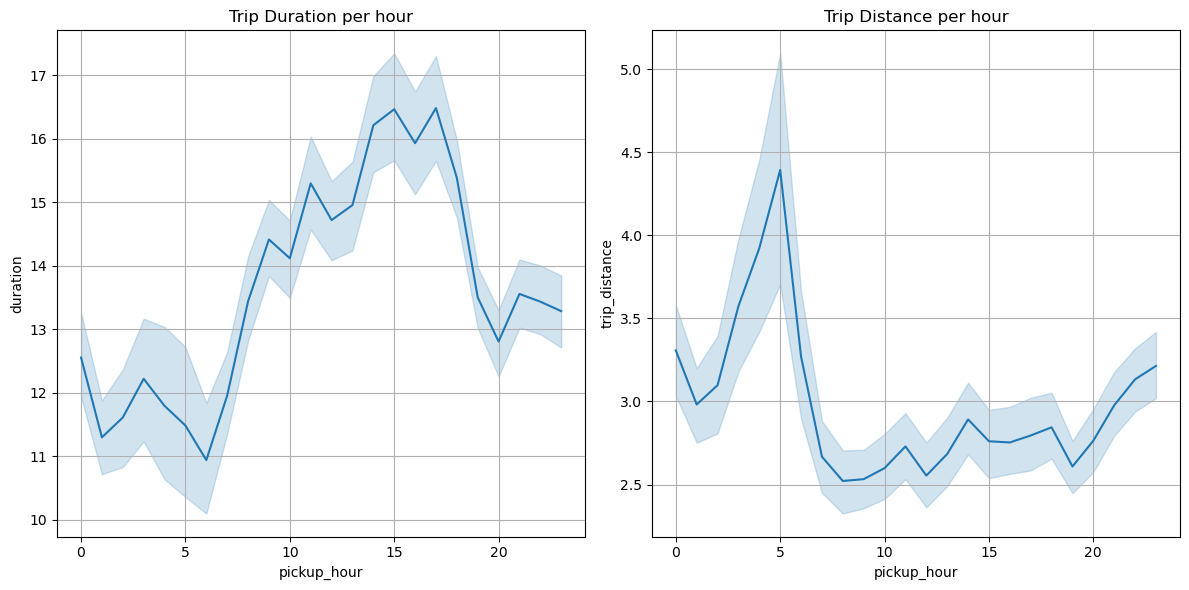

In [56]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot for Trip Duration per time of day
sns.lineplot(x='pickup_hour', y='duration', data=df, ax=axes[0])
axes[0].set_title('Trip Duration per hour')
axes[0].grid(True)  # Enable grid

# Plot for Trip Distance per time of day
sns.lineplot(x='pickup_hour', y='trip_distance', data=df, ax=axes[1])
axes[1].set_title('Trip Distance per hour')
axes[1].grid(True)  # Enable grid

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


We see the trip duration is the maximum around 3 pm which may be because of traffic on the roads.

Trip duration is the lowest around 6 am as streets may not be busy.

distances are the logest around 5pm

### Trips and trip durationper Time of Day

C:\Users\HP\AppData\Local\Temp\ipykernel_5816\4092231640.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="pickup_timeofday", data=df, ax=ax2, palette='Spectral')


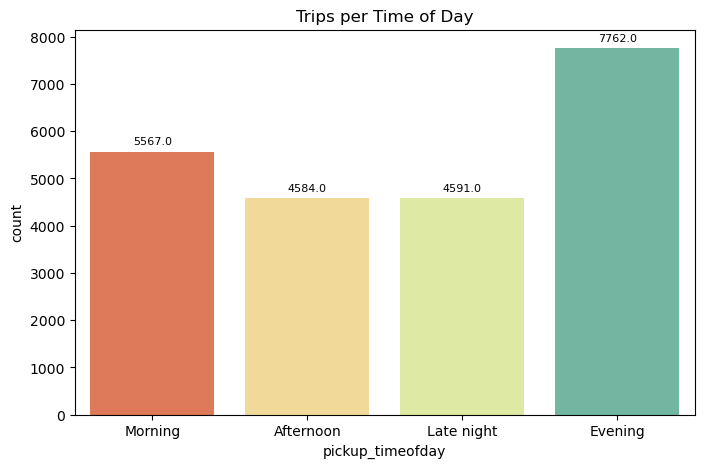

In [57]:
# Create the plot
figure, ax2 = plt.subplots(figsize=(8, 5))
ax2.set_title('Trips per Time of Day')

# Plot the count plot
ax = sns.countplot(x="pickup_timeofday", data=df, ax=ax2, palette='Spectral')

# Annotate the bars with counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')

# Show the plot
plt.show()


it seems evenings are the busiest 

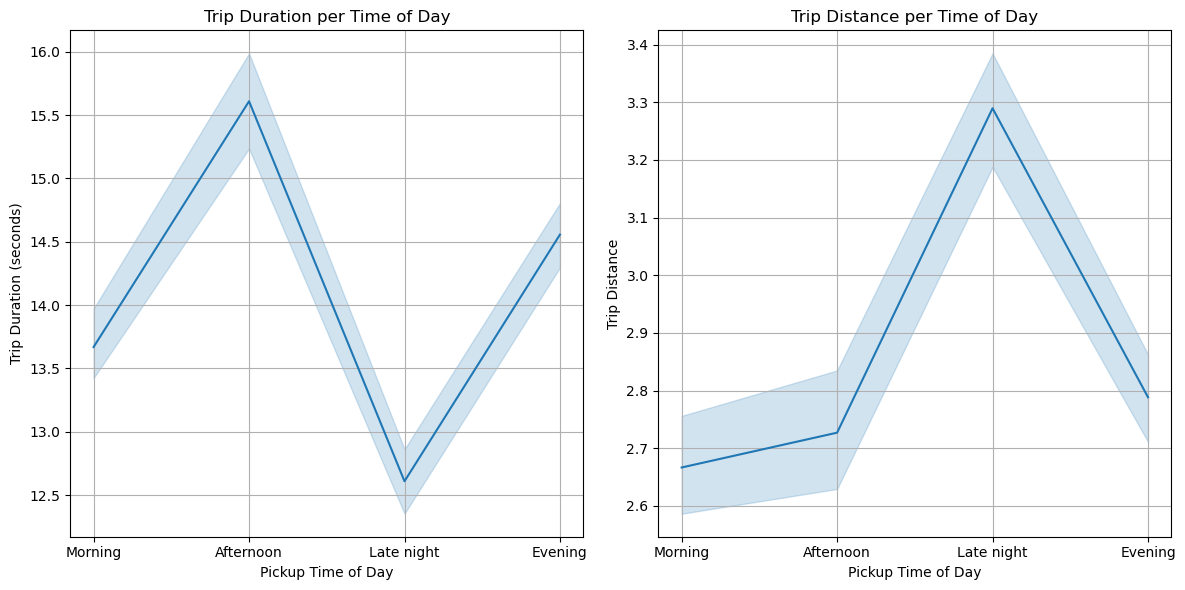

In [58]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot for Trip Duration per time of day
sns.lineplot(x='pickup_timeofday', y='duration', data=df, ax=axes[0])
axes[0].set_title('Trip Duration per Time of Day')
axes[0].set_xlabel('Pickup Time of Day')
axes[0].set_ylabel('Trip Duration (seconds)')
axes[0].grid(True)  # Enable grid

# Plot for Trip Distance per time of day
sns.lineplot(x='pickup_timeofday', y='trip_distance', data=df, ax=axes[1])
axes[1].set_title('Trip Distance per Time of Day')
axes[1].set_xlabel('Pickup Time of Day')
axes[1].set_ylabel('Trip Distance')
axes[1].grid(True)  # Enable grid

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


trip duration is the maximum in the afternoon and lowest between late night and morning. probably because of traffic too

distances being the longest during late night or it maybe called as early morning too.
This can probably point to outstation trips where people start early for the day.

In [59]:
df.head()

id  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0   24870114         2  2017-03-25 08:55:43   2017-03-25 09:09:47   
1   35634249         1  2017-04-11 14:53:28   2017-04-11 15:19:58   
2  106203690         1  2017-12-15 07:26:56   2017-12-15 07:34:08   
3   38942136         2  2017-05-07 13:17:59   2017-05-07 13:48:14   
4   30841670         2  2017-04-15 23:32:20   2017-04-15 23:49:03   

   passenger_count  trip_distance  RatecodeID  store_and_fwd_flag  \
0                6           3.34           1                   0   
1                1           1.80           1                   0   
2                1           1.00           1                   0   
3                1           3.70           1                   0   
4                1           4.37           1                   0   

   PULocationID  DOLocationID  payment_type  fare_amount  duration  \
0           100           231             1         13.0     14.07   
1           186            43             1         16.0     26.50   
2           262           236             1          6.5      7.20   
3           188            97             1         20.5     30.25   
4             4           112             2         16.5     16.72   

   mean_distance  mean_duration  pickup_hour pickup_dayofweek_name  \
0       3.521667      22.848333            8              saturday   
1       3.108889      24.470000           14               tuesday   
2       0.881429       7.250286            7                friday   
3       3.700000      30.250000           13                sunday   
4       4.435000      14.620000           23              saturday   

   pickup_day_of_week  pickup_month pickup_month_name pickup_timeofday  
0                   5             3               Mar          Morning  
1                   1             4               Apr        Afternoon  
2                   4            12               Dec          Morning  
3                   6             5               May        Afternoon  
4                   5             4               Apr       Late night

### Distance and Vendor

<Axes: xlabel='VendorID', ylabel='trip_distance'>

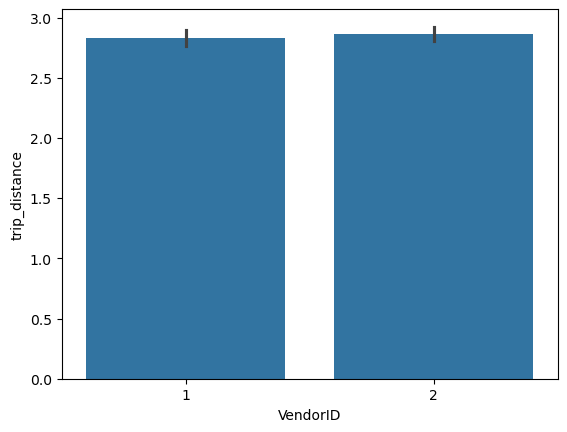

In [60]:
sns.barplot(y='trip_distance',x='VendorID',data=df,estimator=np.mean)

The distribution for both vendors is very similar.

### Passenger Count and Vendor id

<Axes: xlabel='VendorID', ylabel='passenger_count'>

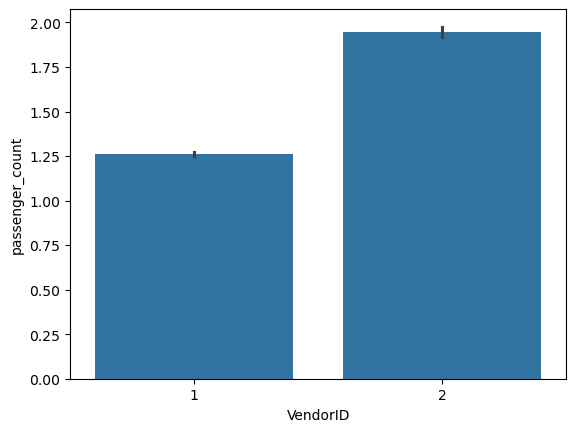

In [61]:
sns.barplot(y='passenger_count',x='VendorID',data=df)

This shows that vendor 2 mostly carries 2 passengers while vendor 1 carries 1 passenger rides.

## Trip Duration and Distance

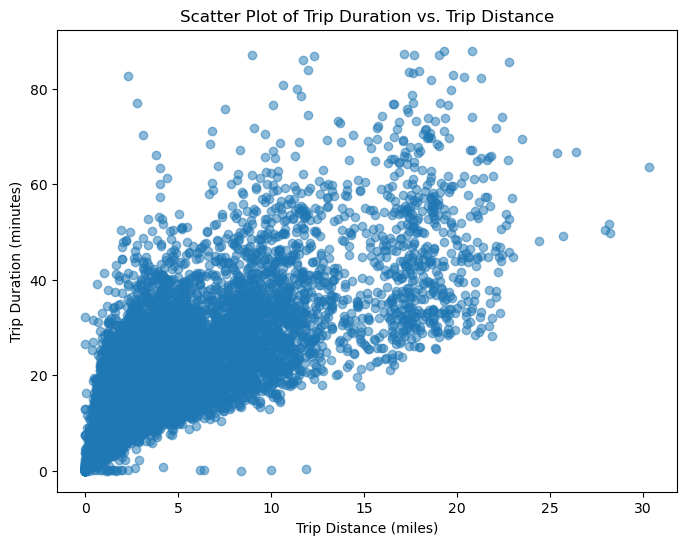

In [62]:
plt.figure(figsize=(8, 6))
plt.scatter(df['trip_distance'], df['duration'], alpha=0.5)
plt.title('Scatter Plot of Trip Duration vs. Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Trip Duration (minutes)')
plt.show()

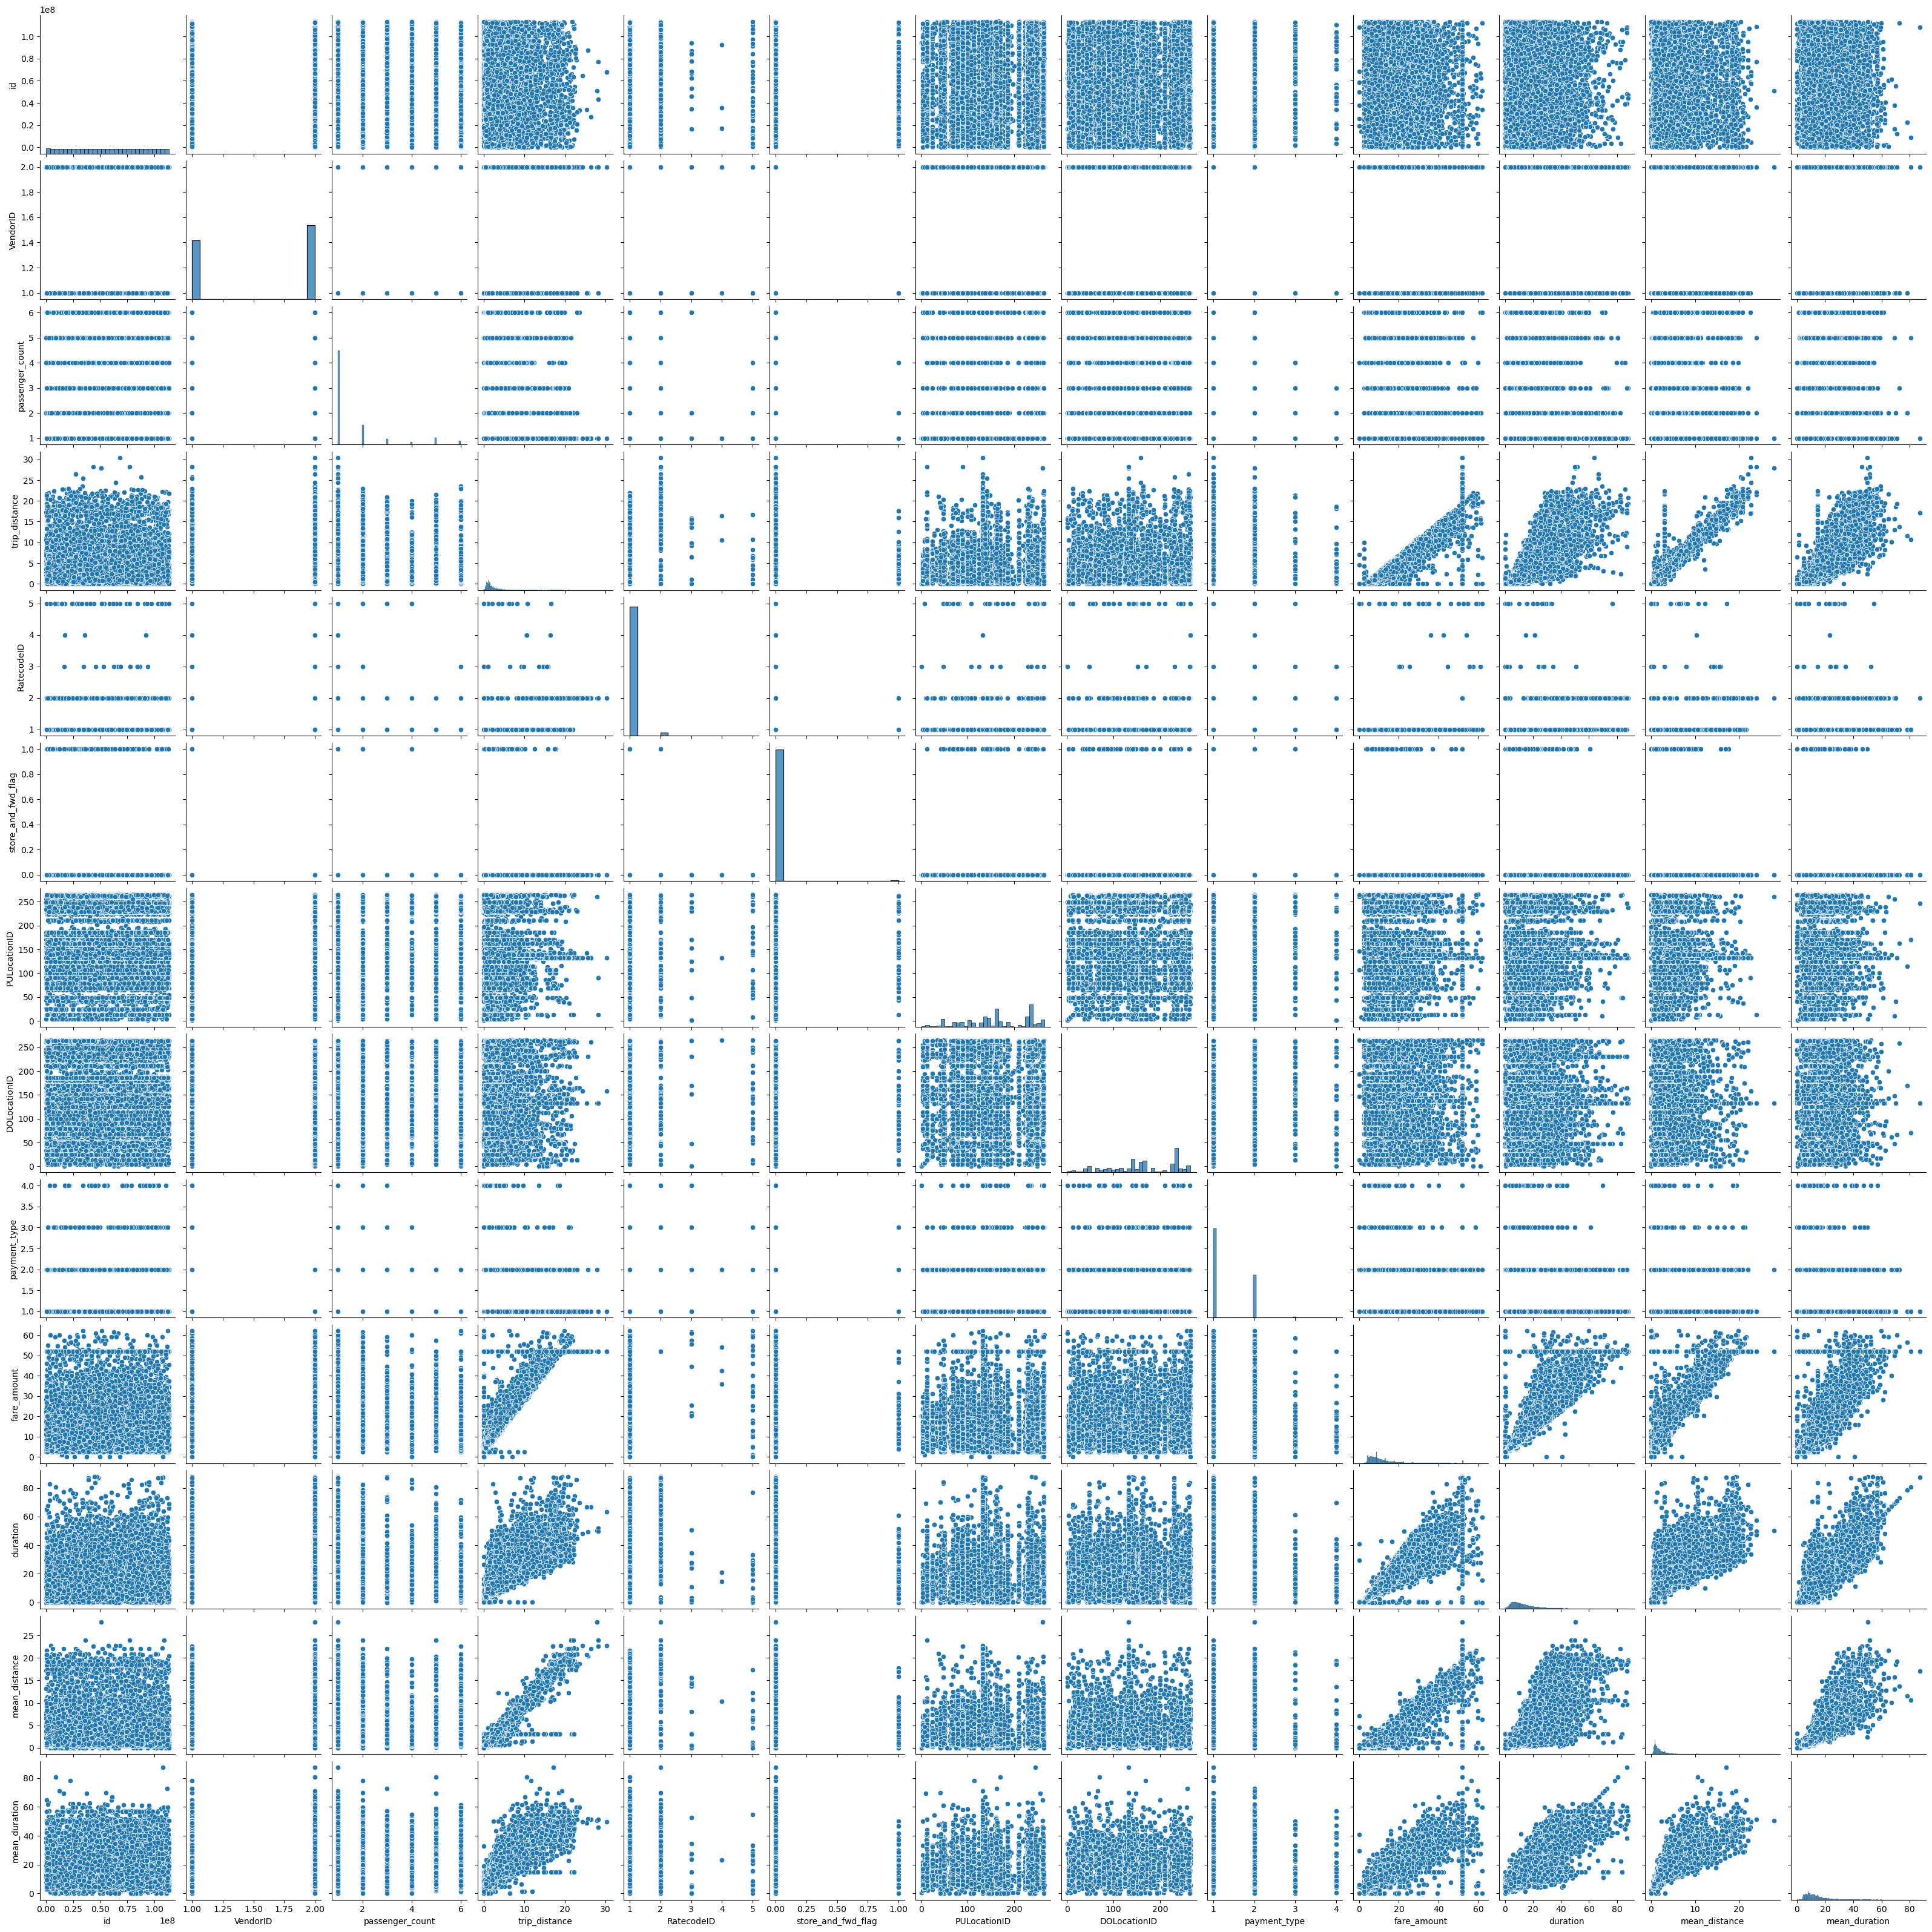

In [63]:
# Select only numerical columns for pair plot
numerical_cols = df.select_dtypes(include=['float64', 'int64'])

# Create pair plot using Seaborn
sns.pairplot(numerical_cols)

# Show the plot
plt.show()

The `mean_duration` and `mean_distance` variable correlates with the target variable. But what are the horizontal lines around fare amounts above $50? What are the values and how many are there?

Check the value of the rides in the horizontal line in the scatter plot.

In [64]:
df[df['fare_amount'] > 50]['fare_amount'].value_counts().head()

fare_amount
52.0    499
59.0      8
50.5      7
51.0      7
57.5      7
Name: count, dtype: int64

There are 499 trips whose fares were $52. 
lets examine them

In [65]:
# Set pandas to display all columns
pd.set_option('display.max_columns', None)
df[df['fare_amount']==52].head(20)

id  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
11    18600059         2  2017-03-05 19:15:30   2017-03-05 19:52:18   
108   47959795         1  2017-06-03 14:24:57   2017-06-03 15:31:48   
159   95729204         2  2017-11-11 20:16:16   2017-11-11 20:17:14   
243  103404868         2  2017-12-06 23:37:08   2017-12-07 00:06:19   
373   80479432         2  2017-09-24 23:45:45   2017-09-25 00:15:14   
382   16226157         1  2017-02-28 18:30:05   2017-02-28 19:09:55   
400   55253442         2  2017-06-05 12:51:58   2017-06-05 13:07:35   
442   65900029         2  2017-08-03 22:47:14   2017-08-03 23:32:41   
461   80904240         2  2017-09-26 13:48:26   2017-09-26 14:31:17   
513   33706214         2  2017-04-23 21:34:48   2017-04-23 22:46:23   
562   99259872         2  2017-11-22 21:31:32   2017-11-22 22:00:25   
565   61050418         2  2017-07-18 13:29:06   2017-07-18 13:29:19   
579   54444647         2  2017-06-26 13:39:12   2017-06-26 14:34:54   
685   94424289         2  2017-11-07 22:15:00   2017-11-07 22:45:32   
709  103094220         1  2017-12-06 05:19:50   2017-12-06 05:53:52   
711   66115834         1  2017-08-04 17:53:34   2017-08-04 18:50:56   
774   55934137         2  2017-06-09 09:31:25   2017-06-09 10:24:10   
808   13731926         2  2017-02-21 06:11:03   2017-02-21 06:59:39   
826    2684305         2  2017-01-10 22:29:47   2017-01-10 23:06:46   
831   90860814         2  2017-10-27 21:50:00   2017-10-27 22:35:04   

     passenger_count  trip_distance  RatecodeID  store_and_fwd_flag  \
11                 2          18.90           2                   0   
108                1          18.00           2                   0   
159                1           0.23           2                   0   
243                1          18.93           2                   0   
373                1          17.99           2                   0   
382                1          18.40           2                   0   
400                1           4.73           2                   0   
442                2          18.21           2                   0   
461                1          17.27           2                   0   
513                6          18.34           2                   0   
562                1          18.65           2                   0   
565                1           0.00           2                   0   
579                1          17.76           2                   0   
685                2          16.97           2                   0   
709                1          20.80           2                   0   
711                1          21.60           2                   0   
774                2          18.81           2                   0   
808                5          16.94           2                   0   
826                1          18.57           2                   0   
831                1          22.43           2                   0   

     PULocationID  DOLocationID  payment_type  fare_amount  duration  \
11            236           132             1         52.0     36.80   
108           132           163             1         52.0     66.85   
159           132           132             2         52.0      0.97   
243           132            79             2         52.0     29.18   
373           132           234             1         52.0     29.48   
382           132            48             2         52.0     39.83   
400           228            88             2         52.0     15.62   
442           132            48             2         52.0     45.45   
461           186           132             2         52.0     42.85   
513           132           148             1         52.0     71.58   
562           132           144             1         52.0     28.88   
565           230           161             1         52.0      0.22   
579           211           132             1         52.0     55.70   
685           132   

It seems that almost all of the trips in the first 30 rows where the fare amount was \$52 either begin or end at location 132, and all of them have a `RatecodeID` of 2.

- There is no readily apparent reason why Location 132 should have so many fares of 52 dollars. 
- They seem to occur on all different days, at different times, with both vendors, in all months. 
- However, there are many toll amounts of $5.76 and $5.54. 
- This would seem to indicate that location 132 is in an area that frequently requires tolls to get to and from.


The data dictionary says that `RatecodeID` of 2 indicates trips for JFK, which is John F. Kennedy International Airport.


### modeling variables

Drop features that are redundant, irrelevant, or that will not be available in a deployed environment.

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22504 entries, 0 to 22503
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     22504 non-null  int64         
 1   VendorID               22504 non-null  int64         
 2   tpep_pickup_datetime   22504 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  22504 non-null  datetime64[ns]
 4   passenger_count        22504 non-null  int64         
 5   trip_distance          22504 non-null  float64       
 6   RatecodeID             22504 non-null  int64         
 7   store_and_fwd_flag     22504 non-null  int64         
 8   PULocationID           22504 non-null  int64         
 9   DOLocationID           22504 non-null  int64         
 10  payment_type           22504 non-null  int64         
 11  fare_amount            22504 non-null  float64       
 12  duration               22504 non-null  float64       
 13  m

In [67]:
df = df.drop(['id', 'tpep_dropoff_datetime', 'tpep_pickup_datetime', 'store_and_fwd_flag', 'payment_type', 
                'pickup_dayofweek_name', 'pickup_month_name'], axis=1)

In [69]:
df = df.drop(['mean_distance', 'mean_duration'], axis=1)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22504 entries, 0 to 22503
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   VendorID            22504 non-null  int64  
 1   passenger_count     22504 non-null  int64  
 2   trip_distance       22504 non-null  float64
 3   RatecodeID          22504 non-null  int64  
 4   PULocationID        22504 non-null  int64  
 5   DOLocationID        22504 non-null  int64  
 6   fare_amount         22504 non-null  float64
 7   duration            22504 non-null  float64
 8   pickup_hour         22504 non-null  int32  
 9   pickup_day_of_week  22504 non-null  int32  
 10  pickup_month        22504 non-null  int32  
 11  pickup_timeofday    22504 non-null  object 
dtypes: float64(3), int32(3), int64(5), object(1)
memory usage: 1.8+ MB


## MODELLING

In [71]:
#Remove the target column from the features
X = df.drop(columns=['fare_amount'])

#Set y variable
y = df[['fare_amount']]

#Display first few rows
X.head()

VendorID  passenger_count  trip_distance  RatecodeID  PULocationID  \
0         2                6           3.34           1           100   
1         1                1           1.80           1           186   
2         1                1           1.00           1           262   
3         2                1           3.70           1           188   
4         2                1           4.37           1             4   

   DOLocationID  duration  pickup_hour  pickup_day_of_week  pickup_month  \
0           231     14.07            8                   5             3   
1            43     26.50           14                   1             4   
2           236      7.20            7                   4            12   
3            97     30.25           13                   6             5   
4           112     16.72           23                   5             4   

  pickup_timeofday  
0          Morning  
1        Afternoon  
2          Morning  
3        Afternoon  
4       Late night

In [72]:
#one hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

In [73]:
X.head()

VendorID  passenger_count  trip_distance  RatecodeID  PULocationID  \
0         2                6           3.34           1           100   
1         1                1           1.80           1           186   
2         1                1           1.00           1           262   
3         2                1           3.70           1           188   
4         2                1           4.37           1             4   

   DOLocationID  duration  pickup_hour  pickup_day_of_week  pickup_month  \
0           231     14.07            8                   5             3   
1            43     26.50           14                   1             4   
2           236      7.20            7                   4            12   
3            97     30.25           13                   6             5   
4           112     16.72           23                   5             4   

   pickup_timeofday_Evening  pickup_timeofday_Late night  \
0                     False                        False   
1                     False                        False   
2                     False                        False   
3                     False                        False   
4                     False                         True   

   pickup_timeofday_Morning  
0                      True  
1                     False  
2                      True  
3                     False  
4                     False

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [75]:
def model_performance(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance.

    model: Regressor model
    predictors: Independent variables
    target: Dependent variable
    """

    # Predict using the independent variables
    pred = model.predict(predictors)

    # Compute regression metrics
    mae = mean_absolute_error(target, pred)  # Mean Absolute Error
    mse = mean_squared_error(target, pred)  # Mean Squared Error
    rmse = mean_squared_error(target, pred, squared=False)  # Root Mean Squared Error
    r2 = r2_score(target, pred)  # R-squared score


    # Create a DataFrame of metrics
    df_perf = pd.DataFrame({
        "MAE": [mae],
        "MSE": [mse],
        "RMSE": [rmse],
        "R-squared": [r2] 
    })

    return df_perf


In [76]:

# Create and train the linear regression model
LRmodel = LinearRegression()
LRmodel.fit(X_train, y_train)


LinearRegression()

In [77]:
LRtrain = model_performance(LRmodel, X_train, y_train)
LRtrain

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE       MSE      RMSE  R-squared
0  0.80457  6.246738  2.499348   0.937517

In [78]:
LRtest = model_performance(LRmodel, X_test, y_test)
LRtest

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE       MSE      RMSE  R-squared
0  0.823309  6.757737  2.599565   0.934669

In [79]:
# Initialize the XGBoost regressor model
from xgboost import XGBRegressor

xgb_regressor = XGBRegressor()

# Training the XGBoost regressor model
xgb_regressor.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [80]:
xgbtrain = model_performance(xgb_regressor, X_train, y_train)
xgbtrain

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE       MSE      RMSE  R-squared
0  0.215834  0.095353  0.308792   0.999046

In [81]:
xgbtest = model_performance(xgb_regressor, X_test, y_test)
xgbtest

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE       MSE      RMSE  R-squared
0  0.40796  2.767518  1.663586   0.973245

## Residuals Analysis: Analyzed residuals to check for patterns and model fit.

#### xgb_regressor Model

In [82]:
# Make predictions on the test set
# Residual Analysis
y_pred_train = xgb_regressor.predict(X_train)
y_pred_test = xgb_regressor.predict(X_test)

Text(0.5, 1.0, 'Actual vs Predicted Fare Amount')

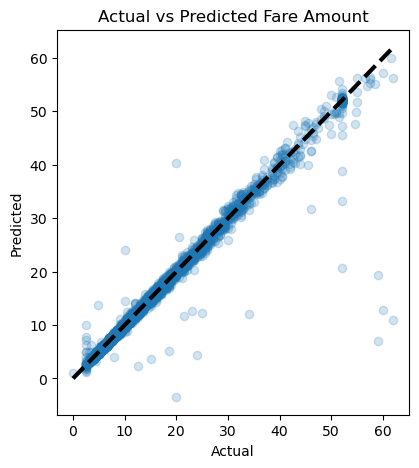

In [83]:
plt.figure(figsize=(10, 5))

# Scatter plot of actual vs predicted fare amount
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Fare Amount')



Many points are close to the black dashed line, indicating that the model's predictions are close to the actual fare amounts.

There are some deviations from the line, especially for lower fare amounts, indicating discrepancies between actual and predicted values.

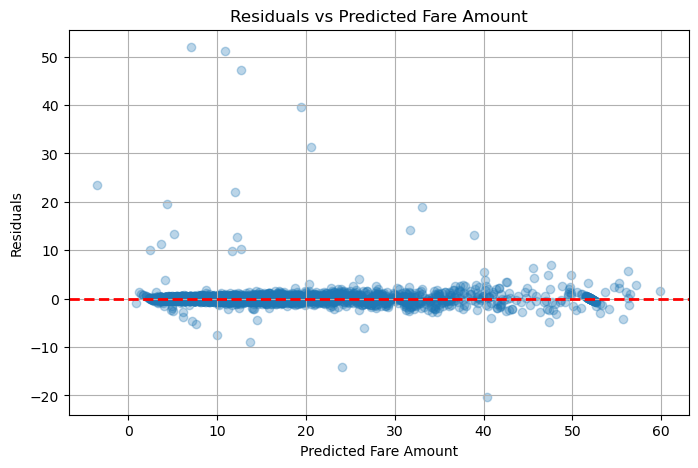

In [84]:
# Calculate residuals
residuals = y_test.values.reshape(-1, 1) - y_pred_test.reshape(-1, 1)

# Create a scatter plot of predicted values vs. residuals
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_test, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Fare Amount')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Fare Amount')
plt.grid(True)
plt.show()

The model's residuals are evenly distributed above and below zero

The residuals are mostly centered around zero, indicating that the model's predictions are generally unbiased.

#Save the trained model
#joblib.dump(best_xgb_model, 'best_xgb_model.pkl')

In [85]:
import pickle

In [86]:
# Save the model
model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'taxi_fare_model.pkl')
with open(model_path, 'wb') as file:
    pickle.dump(xgb_regressor, file)

# Save the columns for later use
columns_path = os.path.join(model_dir, 'model_columns.pkl')
with open(columns_path, 'wb') as file:
    pickle.dump(X.columns.tolist(), file)

print(f"Model and columns saved successfully in '{model_dir}' directory.")


Model and columns saved successfully in '../models' directory.
